In [10]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import math
import os
import pandas as pd
from sklearn import preprocessing

In [94]:
# Model Architecture Defs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#MLP
def build_model(X_,_dropout,node_sizes,net_type):
    if net_type == 'mlpnet':
        model_out,l2,l1 = mlpnet(X_,_dropout,node_sizes)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model_out,l2,l1

def mlpnet(image,_dropout,node_sizes):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
#     l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
#     l3 = tf.nn.dropout(l3,1)
    l4 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l4')
    return l4,l2,l1

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
        #return tf.nn.relu(tf.matmul(input_,w))
        return tf.nn.tanh(tf.matmul(input_,w))
    
    
def next_batch(s,e,inputs,labels):
    input1 = inputs[s:e]
    y = np.reshape(labels[s:e],(len(range(s,e)),2))
    return input1,y

def compute_accuracy(prediction,labels):
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return acc

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f,protocol=2)
    f.close()

In [118]:
# Load Data

baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'
demo_cols = ['AGE','APOE4']
exp_name = 'Exp_102_ADNI2_traj_MMSE_tp_var_tp'
use_ct = True
use_cs = True
var_tp = True
shuffle_labels = False # What's your performance with random labels. 
scale_data = True


exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'

with open(exp_setup_path, 'rb') as f:
    exp_setup = pickle.load(f, encoding='latin') 


#Check if loading the correct experimental setup
if exp_name != exp_setup['exp_name']:
    print('Incorrect exp_name. Selected:{}, Retrieved:{}'.format(exp_name, exp_setup['exp_name']))

else:
    print('exp_name: {}'.format(exp_name))
    
    df = exp_setup['df']
    kf = exp_setup['sKF']
    
    feat_cols = []   
    feat_sufix = ''
    
    if use_cs:
        print('using CS columns')
        if var_tp:
            cs_cols = ['MMSE_bl','MMSE_var_tp'] + demo_cols
        else:
            cs_cols = ['MMSE_bl'] + demo_cols
        feat_cols = feat_cols + cs_cols
        feat_sufix = feat_sufix + '_CS'
        print(len(feat_cols))
        
    if use_ct:   
        if var_tp:
            ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
            ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])
            ct_cols = ct_cols_bl + ct_cols_tp_rate
        else:
            ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])

        feat_cols = feat_cols + ct_cols
        feat_sufix = feat_sufix + '_CT_raw' 

    X_raw = np.array(df[feat_cols]) #Otherwise scaling and shifting will remain the same for next model. 
    y = np.array(df['traj']) 
    if shuffle_labels:
        print('shuffling labels')
        np.random.shuffle(y)
    
    print('X,y shapes:{},{}'.format(X_raw.shape,y.shape))
    
    # Create list of all the fold-subsets (needed for parallelization)
    Sub_train_kf =[]
    Sub_test_kf = []
    X_train_kf = []
    X_test_kf = []
    y_train_kf = []
    y_test_kf = []    

    start_time = time.time()
    for train, test in kf:
        Sub_train_kf.append(df['PTID'].values[train]) 
        Sub_test_kf.append(df['PTID'].values[test]) 
        X_tr = X_raw[train]
        y_tr = y[train]
        X_te = X_raw[test]
        y_te = y[test]

        if scale_data:
            scaler = preprocessing.StandardScaler().fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_te = scaler.transform(X_te)
            
            
        X_train_kf.append(X_tr)
        y_train_kf.append(y_tr)

        # No need to resample test data
        X_test_kf.append(X_te)            
        y_test_kf.append(y_te)

exp_name: Exp_102_ADNI2_traj_MMSE_tp_var_tp
using CS columns
4
X,y shapes:(566, 160),(566,)


In [119]:
# Setup and Run TF
tf.logging.set_verbosity(tf.logging.ERROR)

batch_size = 100
num_epochs = 200

lr = 0.0005
keep_p = 0.5

model_choice = 'ANN_Layer2'

#Track performance for each fold
kf_train_acc = []
kf_valid_acc = []
kf_test_acc = []
df_perf_concat = pd.DataFrame()

n_folds = 10
save_perf = True
start_time = time.time()
for kf in np.arange(n_folds):    
    
    train_subx = X_train_kf[kf].shape[0]
    featx = X_train_kf[kf].shape[1]

    train_valid_split = 0.9*train_subx
    X_train = X_train_kf[kf][:train_valid_split,:]
    y_train = y_train_kf[kf][:train_valid_split]
    X_valid = X_train_kf[kf][train_valid_split:,:]
    y_valid = y_train_kf[kf][train_valid_split:]

    X_test = X_test_kf[kf]
    y_test = y_test_kf[kf]

    #One-hot encoding for the labels
    y_train = np.vstack((np.array(y_train==0).astype(int),np.array(y_train==1).astype(int))).T
    y_valid = np.vstack((np.array(y_valid==0).astype(int),np.array(y_valid==1).astype(int))).T
    y_test = np.vstack((np.array(y_test==0).astype(int),np.array(y_test==1).astype(int))).T


    print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)
    print(np.mean(X_train),np.mean(y_train))
    
    train_loss = []
    train_acc = []
    valid_acc = []
    test_acc = []
    df_perf = pd.DataFrame()
    
    # Add ops to save and restore all the variables.
    
    node_sizes = {'input':featx,'l1':25,'l2':25,'l3':20,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}
    with tf.Graph().as_default():    
        data = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='input_data')        
        labels = tf.placeholder(tf.float32,shape=([None,2]),name='gt')                
        dropout_f = tf.placeholder("float")

        with tf.variable_scope("adninet") as scope:
            model_out,l2,l1= build_model(data,dropout_f,node_sizes,'mlpnet')            
            
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model_out,labels))         
        acc = compute_accuracy(model_out,labels)
        
#         t_vars = tf.trainable_variables()
#         d_vars  = [var for var in t_vars if 'l' in var.name]
#         batch = tf.Variable(0)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)
                
        # Launch the graph        
        with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
            #sess.run(init)
            tf.initialize_all_variables().run()
            saver = tf.train.Saver()
            # Training cycle
            for epoch in range(num_epochs):
                avg_loss = 0.
                avg_acc = 0.
                total_batch = int(X_train.shape[0]/batch_size)
                
                # Loop over all batches
                for i in range(total_batch):
                    s  = i * batch_size
                    e = (i+1) *batch_size
                    
                    # Fit training using batch data
                    tr_X,tr_y = next_batch(s,e,X_train,y_train)  
                    #print(tr_X.shape, tr_y.shape)
                                
                    _,tr_loss,tr_acc=sess.run([optimizer,loss,acc], 
                                                  feed_dict={data:tr_X,labels:tr_y,dropout_f:keep_p})
                    
                    predict=model_out.eval(feed_dict={data:tr_X,dropout_f:1.0})                    
                    tr_acc = compute_accuracy(predict,tr_y).eval()                
                                        
                    #print(tr_acc.eval())
#                     if math.isnan(tr_acc) and epoch != 0:
#                         print('tr_acc %0.2f' % tr_acc)
#                         pdb.set_trace()

                    avg_loss += tr_loss
                    avg_acc +=tr_acc*100
                                        
                #print('epoch %d loss %0.2f' %(epoch,avg_loss/total_batch))
                duration = time.time() - start_time
                #print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))
                train_loss.append(avg_loss/(total_batch))
                train_acc.append(avg_acc/total_batch)
                
                #Check performance on validation set                                                                                
                predict = model_out.eval(feed_dict={data:X_valid,dropout_f:1.0})                
                va_acc = compute_accuracy(predict,y_valid).eval()*100.0
                valid_acc.append(va_acc)
                
                # Test model                                    
                predict= model_out.eval(feed_dict={data:X_test,dropout_f:1.0})                
                te_acc = compute_accuracy(predict,y_test).eval()*100
                test_acc.append(te_acc)
                
                
                if epoch%10 == 0:
                    print('Epoch:{}, Accuracy train:{:4.3f},valid:{:4.3f}'.format(epoch,tr_acc,va_acc))
                    
            #Accuracy of the entire training set at the end of training            
            train_predict = model_out.eval(feed_dict={data:X_train, dropout_f:1.0})         
            train_embed_l1 = l1.eval(feed_dict={data:X_train, dropout_f:1.0})  
            train_embed_l2 = l2.eval(feed_dict={data:X_train, dropout_f:1.0})  
#             train_embed_l3 = l3.eval(feed_dict={data:X_train, dropout_f:1.0})  
            tr_acc = compute_accuracy(train_predict,y_train).eval()*100
            print('Accuracy at the end of training: train:{:4.3f},valid:{:4.3f}'.format(epoch,tr_acc,va_acc))           

            # Test model                                    
            test_predict = model_out.eval(feed_dict={data:X_test,dropout_f:1.0})                
            test_embed_l1 = l1.eval(feed_dict={data:X_test, dropout_f:1.0})  
            test_embed_l2 = l2.eval(feed_dict={data:X_test, dropout_f:1.0})  
#             test_embed_l3 = l3.eval(feed_dict={data:X_test, dropout_f:1.0})  
            te_acc = compute_accuracy(test_predict,y_test).eval()            
            print('Accuracy test set %0.3f' % (100 * te_acc))
                  
            #Save perf method 1: df of all subjects
            df_perf['PTID'] = Sub_test_kf[kf]
            df_perf['model'] = np.tile(model_choice,len(y_test))
            df_perf['kf'] = np.tile(kf+1,len(y_test))
            df_perf['act_label'] = np.argmax(y_test,1)
            df_perf['pred_label'] = np.argmax(predict,1)
            a = np.exp(predict)
            b= np.sum(a,axis=1).reshape(len(a),1)
            y_pred_prob = np.divide(a,b)
            df_perf['pred_prob'] = list(y_pred_prob)            
            df_perf['test_embed_l1'] = list(test_embed_l1)
            df_perf['test_embed_l2'] = list(test_embed_l2)
            
            df_perf_concat = df_perf_concat.append(df_perf)
            save_path = saver.save(sess, '{}TF_models/{}_{}{}_{}.ckpt'.format(baseline_dir,exp_name,
                                                                            model_choice,feat_sufix,kf))
            print("Model saved in file: %s" % save_path)
            
        kf_train_acc.append(tr_acc)
        kf_valid_acc.append(va_acc)
        kf_test_acc.append(te_acc)
                                   
            
#Save perf df
if save_perf:
    pickleIt(df_perf_concat, '{}TF_perf/{}_{}{}_df_perf.pkl'.format(baseline_dir,exp_name,model_choice,feat_sufix)) 
    
print('total_time:: {}'.format((time.time() - start_time)/60.0))

/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(458, 160) (458, 2) (51, 160) (51, 2) (57, 160) (57, 2)
0.00337318663007 0.5
Epoch:0, Accuracy train:0.660,valid:49.020
Epoch:10, Accuracy train:0.790,valid:52.941
Epoch:20, Accuracy train:0.810,valid:60.784
Epoch:30, Accuracy train:0.880,valid:64.706
Epoch:40, Accuracy train:0.900,valid:70.588
Epoch:50, Accuracy train:0.890,valid:70.588
Epoch:60, Accuracy train:0.910,valid:78.431
Epoch:70, Accuracy train:0.920,valid:76.471
Epoch:80, Accuracy train:0.930,valid:78.431
Epoch:90, Accuracy train:0.930,valid:80.392
Epoch:100, Accuracy train:0.930,valid:80.392
Epoch:110, Accuracy train:0.950,valid:82.353
Epoch:120, Accuracy train:0.950,valid:80.392
Epoch:130, Accuracy train:0.950,valid:80.392
Epoch:140, Accuracy train:0.960,valid:80.392
Epoch:150, Accuracy train:0.970,valid:82.353
Epoch:160, Accuracy train:0.970,valid:82.353
Epoch:170, Accuracy train:0.970,valid:82.353
Epoch:180, Accuracy train:0.970,valid:82.353
Epoch:190, Accuracy train:0.970,valid:84.314
Accuracy at the end of training: t

In [85]:
# exp_perf_path = baseline_dir + 'TF_perf/ANN_Layer2_df_perf.pkl'

# with open(exp_perf_path, 'rb') as f:
#     perf_df = pickle.load(f, encoding='latin') 
    
perf_df

,PTID,model,kf,act_label,pred_label,pred_prob,test_embed_l1,test_embed_l2
0,002_S_4171,ANN_Layer2,1,1,1,"[0.222917, 0.777083]","[-0.541674, -0.999785, -0.999995, -0.316601, 0...","[0.0890689, 0.00347788, -0.360632, 0.439052, 0..."
1,002_S_4213,ANN_Layer2,1,0,0,"[0.820862, 0.179138]","[-0.383847, -1.0, -1.0, -0.337454, 0.137691, 0...","[-0.403278, -0.611238, -0.138028, 0.379995, 0...."
2,002_S_4219,ANN_Layer2,1,0,0,"[0.859236, 0.140764]","[-0.33525, -1.0, -1.0, -0.490358, 0.211902, 0....","[-0.373341, -0.559956, -0.136371, 0.388275, 0...."
3,002_S_4225,ANN_Layer2,1,0,0,"[0.863206, 0.136794]","[-0.481248, -1.0, -1.0, -0.446953, 0.419329, 0...","[-0.432821, -0.63833, -0.0564129, 0.494102, 0...."
4,002_S_4229,ANN_Layer2,1,0,0,"[0.769424, 0.230576]","[-0.565077, -1.0, -1.0, -0.439908, 0.257637, 0...","[-0.277597, -0.542717, -0.167939, 0.423046, 0...."
5,002_S_4237,ANN_Layer2,1,0,1,"[0.217248, 0.782752]","[-0.103431, -1.0, -1.0, -0.248602, -0.128361, ...","[-0.213302, -0.727061, -0.375717, 0.584731, 0...."
6,002_S_4251,ANN_Layer2,1,0,0,"[0.726843, 0.273157]","[-0.435443, -1.0, -1.0, -0.448151, 0.21628, 0....","[-0.355629, -0.580262, -0.225391, 0.43003, 0.6..."
7,002_S_4262,ANN_Layer2,1,1,0,"[0.670848, 0.329152]","[-0.414715, -1.0, -1.0, -0.179342, 0.292739, 0...","[-0.308655, -0.61523, -0.130162, 0.559142, 0.5..."
8,002_S_4270,ANN_Layer2,1,0,0,"[0.680519, 0.319481]","[-0.410327, -1.0, -1.0, -0.616581, 0.121541, 0...","[-0.367829, -0.658563, -0.175828, 0.53406, 0.6..."
9,002_S_4447,ANN_Layer2,1,0,0,"[0.742379, 0.257621]","[-0.344686, -1.0, -1.0, -0.478079, 0.301167, 0...","[-0.234566, -0.511123, -0.0577056, 0.376033, 0..."


In [120]:
print(kf_train_acc)
print(kf_valid_acc)
print(kf_test_acc)
print(np.mean(kf_train_acc),np.mean(kf_valid_acc),np.mean(kf_test_acc))

[96.069872379302979, 95.19650936126709, 96.506547927856445, 95.196503400802612, 96.943223476409912, 95.19650936126709, 95.633184909820557, 95.860564708709717, 94.989103078842163, 95.206975936889648]
[82.352948188781738, 86.274516582489014, 82.352948188781738, 86.274516582489014, 80.392158031463623, 86.274516582489014, 84.313732385635376, 80.392158031463623, 82.352948188781738, 86.538463830947876]
[0.92982459, 0.89473689, 0.82456142, 0.89473689, 0.78947371, 0.91228074, 0.89473689, 0.92857146, 0.91071427, 0.89090908]
95.6798994541 83.7518906593 0.887055


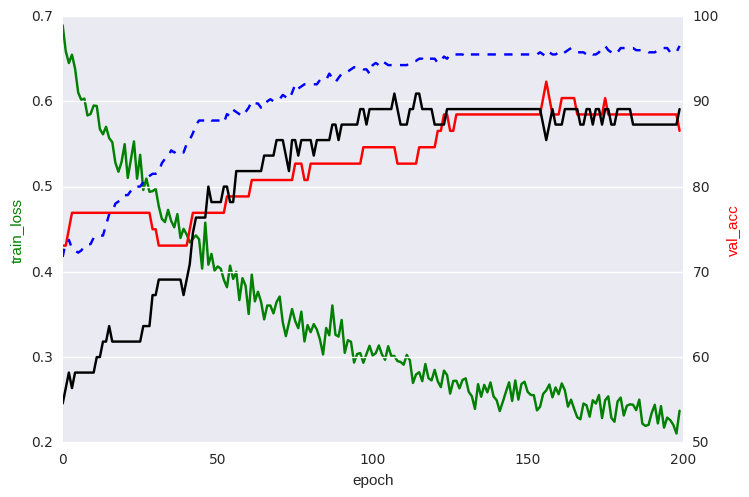

In [121]:
# Plot Acc and Loss
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b--')
ax2.plot(valid_acc, 'r-')
ax2.plot(test_acc, 'k-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('val_acc', color='r')
ax1.grid()

In [124]:
#TSNE
from sklearn.manifold import TSNE
tsne_df = pd.DataFrame()

tsne_df_train = pd.DataFrame()
tsne_df_train['PTID'] = Sub_train_kf[kf][:train_valid_split]
tsne_df_train['labels'] = np.argmax(y_train,1)
tsne_df_train['subset'] = np.tile('train',len(y_train))
tsne_df_train['KF'] = np.tile(kf,len(y_train))

tsne_df_test = pd.DataFrame()
tsne_df_test['PTID'] = Sub_test_kf[kf]
tsne_df_test['labels'] = np.argmax(y_test,1)
tsne_df_test['subset'] = np.tile('test',len(y_test))
tsne_df_test['KF'] = np.tile(kf,len(y_test))

tsne_train_layers = {'l1':train_embed_l1,'l2':train_embed_l2}
tsne_test_layers = {'l1':test_embed_l1,'l2':test_embed_l2}

for l in tsne_train_layers:
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(tsne_train_layers[l])
    tsne_df_train['TSNE_{}_x'.format(l)] = tsne_embed[:,0]
    tsne_df_train['TSNE_{}_y'.format(l)] = tsne_embed[:,1]

for l in tsne_test_layers:
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(tsne_test_layers[l])
    tsne_df_test['TSNE_{}_x'.format(l)] = tsne_embed[:,0]
    tsne_df_test['TSNE_{}_y'.format(l)] = tsne_embed[:,1]

tsne_df = tsne_df_train.append(tsne_df_test)

/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


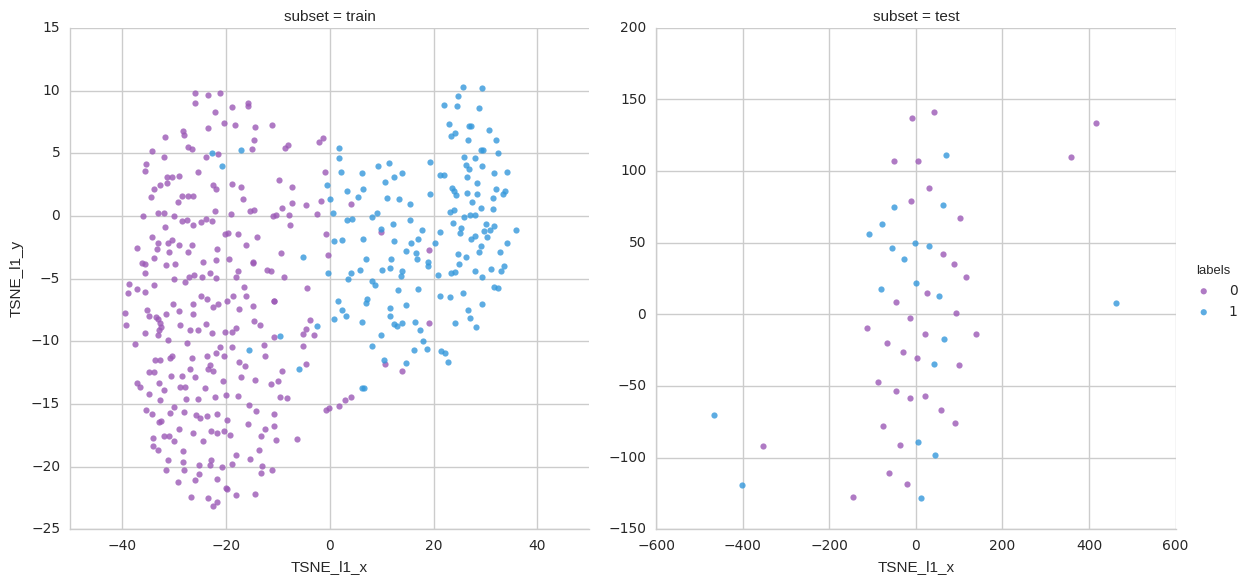

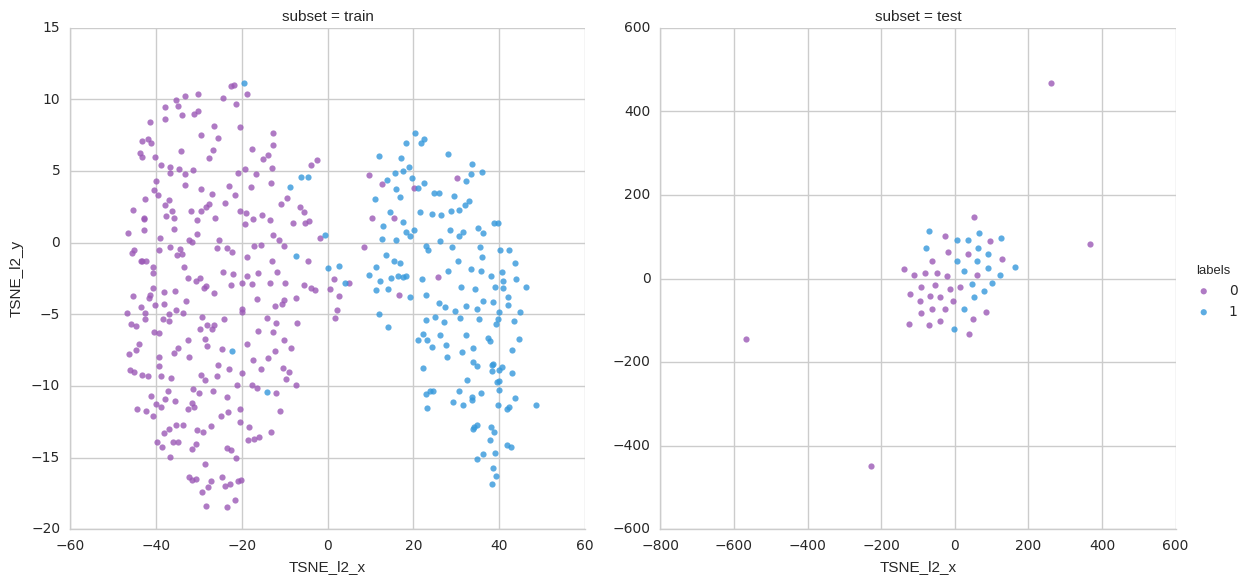

In [125]:
import seaborn as sns
#df_perf = pd.merge(df_perf,df[['PTID','DX_bl']],on='PTID',how='inner')
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71", "#95a5a6"]

with sns.axes_style("whitegrid"):
    g1 = sns.lmplot('TSNE_l1_x','TSNE_l1_y',fit_reg=False,hue='labels',col='subset',data=tsne_df,
                    markers='o',size=6,sharey=False,sharex=False,palette=flatui)
    g1 = sns.lmplot('TSNE_l2_x','TSNE_l2_y',fit_reg=False,hue='labels',col='subset',data=tsne_df,
                    markers='o',size=6,sharey=False,sharex=False,palette=flatui) 

In [128]:
Sub_train_kf[kf].shape, tsne_L1.shape

((619,), (557, 2))